In [1]:
# import ee
from IPython import display
# import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
import rasterio
from zipfile import *
import math
from math import sqrt
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
import time

In [30]:
import os

path = 'C:/Users/ipdavies/CPR/data/'

# Get list of all images
img_list = []
for file in os.listdir(path):
        img_list.append(file)

print(img_list)

img = '4101_LC08_027039_20131103_1'
file_list = []
path = path+'images/'+img
feat_list_new = ['aspect','curve', 'developed', 'GSW_distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']

['.ipynb_checkpoints', 'cloudmasks', 'clouds', 'images', 'models', 'tables']


Assuming tifs are already stacked into a "stack.tif" image

In [31]:
# This gets the name of all files in the zip folder, and formats them into a full path readable by rasterio.open()
with ZipFile(path + '/' + img + '.zip', 'r') as f:
    names = f.namelist()
    names = ['zip://'+ path + '/' + img + '.zip!' +name for name in names]
    for file in names:
        if file.endswith('.tif'):
            file_list.append(file)

feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # Grabs a list of features in file order        

# if overwrite==False:
#         if os.path.exists(path + '/stack/stack.tif') == True:
#             print('"stack.tif" already exists for '+ img)
#             return
#         else:
#             print('No existing "stack.tif" for '+img+', creating one')

# if overwrite==True:
#     # Remove stack file if already exists
#     try:
#         os.remove(path + '/stack/stack.tif')
#         print('Removing existing "stack.tif" and creating new one')
#     except FileNotFoundError:
#         print('No existing "stack.tif" for '+img+', creating one')

# Create 1 row df of file names where each col is a feature name, in the order files are stored locally
file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

# Then index the file list by the ordered list of feature names used in training
file_arr = file_arr.loc[:, feat_list_new]

# The take this re-ordered row as a list - the new file_list
file_list = list(file_arr.iloc[0,:])

# Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
# and we are converting the other bands to float64
with rasterio.open(file_list[1]) as src0:
    meta = src0.meta
    meta['dtype'] = 'float32'
#         print(meta)

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer, convert to float, and write it to stack
# There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

# # Make new directory for stacked tif if it doesn't already exist
# try:
#     os.mkdir(path +'/stack')
# except FileExistsError:
#     print('Stack directory already exists') 

with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=0):
        print(layer)
        with rasterio.open(layer) as src1:
            dst.write_band(id+1, src1.read(1).astype('float32'))


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.aspect.tif
zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.curve.tif
zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.developed.tif
zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.GSW_distExtent.tif
zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.elevation.tif
zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.forest.tif
zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027039_20131103_1/4101_LC08_027039_20131103_1.zip!4101_LC08_027039_20131103_1.GSW_maxExtent.tif
zip://C

In [32]:
path = 'C:/Users/ipdavies/CPR/data/'

# Get local image
with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

# Convert -999999 to None
data[data <= -999999] = np.nan

# Reshape into a single vector of pixels.
data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

# Remove NaNs
data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]

df = pd.DataFrame(data = np.round(data_vector, 2), columns = feat_list_new)

In [33]:
df.head

<bound method NDFrame.head of              aspect  curve  developed  GSW_distExtent  elevation  forest  \
0          0.000000   5.13        0.0            65.0      295.0     0.0   
1        310.540009   0.08        0.0            68.0      296.0     0.0   
2        310.540009  -6.64        0.0            73.0      298.0     1.0   
3         11.030000  -2.39        0.0            80.0      299.0     1.0   
4         11.030000   6.63        0.0            89.0      297.0     1.0   
5        322.059998   4.37        0.0           100.0      298.0     1.0   
6        310.540009  -3.72        0.0           113.0      301.0     1.0   
7        329.690002  -7.15        0.0           128.0      303.0     1.0   
8          0.000000  -3.03        0.0           145.0      303.0     1.0   
9        329.690002   0.71        0.0           164.0      303.0     1.0   
10         0.000000  -5.71        0.0           185.0      304.0     1.0   
11        49.459999  -1.06        0.0           208.0     

In [34]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,aspect,curve,developed,GSW_distExtent,elevation,forest,GSW_maxExtent,hand,other_landcover,planted,slope,spi,twi,wetlands,flooded
aspect,1,-0.000976362,0.0865385,0.152456,0.416955,0.112766,-0.0595433,0.277763,0.176873,0.140671,0.405098,0.0358067,0.26488,0.038599,-0.064585
curve,-0.000976362,1,-0.00639198,-0.000548857,-0.0181523,-0.0505443,0.0210429,-0.272795,0.0288292,0.0156408,-0.00463521,0.00212367,0.00611321,-0.0223217,0.0138167
developed,0.0865385,-0.00639198,1,0.0718564,0.182114,-0.128334,-0.0318064,0.0757265,-0.219038,-0.183058,0.0850281,-0.0141442,0.0993316,-0.0481848,-0.0294688
GSW_distExtent,0.152456,-0.000548857,0.0718564,1,0.398606,0.153678,-0.0666686,0.150719,0.135772,-0.0422091,0.151687,-0.03831,0.195048,-0.0164863,-0.0576658
elevation,0.416955,-0.0181523,0.182114,0.398606,1,0.282818,0.0198089,0.446784,0.41453,-0.081591,0.459598,-0.0272443,0.595852,-0.0125663,0.0136365
forest,0.112766,-0.0505443,-0.128334,0.153678,0.282818,1,-0.0372221,0.311051,-0.266115,-0.222402,0.210318,-0.00388066,0.118425,-0.0585408,-0.0342407
GSW_maxExtent,-0.0595433,0.0210429,-0.0318064,-0.0666686,0.0198089,-0.0372221,1,-0.0666403,-0.0465936,-0.0554482,-0.0402716,0.0243326,0.240789,-0.0067437,0.803963
hand,0.277763,-0.272795,0.0757265,0.150719,0.446784,0.311051,-0.0666403,1,0.129635,-0.0780746,0.449587,0.00679652,0.219987,0.0131032,-0.0618073
other_landcover,0.176873,0.0288292,-0.219038,0.135772,0.41453,-0.266115,-0.0465936,0.129635,1,-0.379591,0.19404,-0.0230537,0.218743,-0.0999162,-0.0521685
planted,0.140671,0.0156408,-0.183058,-0.0422091,-0.081591,-0.222402,-0.0554482,-0.0780746,-0.379591,1,0.0251539,0.0276106,0.226489,-0.0835035,-0.0454896


In [46]:
with rasterio.open('zip://C:/Users/ipdavies/CPR/data/images/4101_LC08_027038_20131103_1/4101_LC08_027038_20131103_1.zip!4101_LC08_027038_20131103_1.GSW_maxExtent.tif', 'r') as ds:
    data = ds.read()
    print(np.unique(data))
#     plt.imshow(data)
    

RasterioIOError: '/vsizip/C:/Users/ipdavies/CPR/data/images/4101_LC08_027038_20131103_1/4101_LC08_027038_20131103_1.zip/4101_LC08_027038_20131103_1.GSW_maxExtent.tif' does not exist in the file system, and is not recognized as a supported dataset name.

In [45]:
with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
    data = ds.read()
#     data[data == -999999] = np.nan
    data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])
    print(data_vector)
    data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)

[[-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]]


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less_equal
  


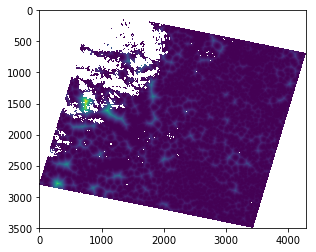

In [61]:
np.unique(data[:,:,1])
data[data <= -999999] = np.nan
data[~np.isnan(data).any(axis=2)]
plt.imshow(data[:,:,3])

In [62]:
np.sum(data[:,:,3])

nan

In [5]:
print(data[:,:,0])

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [7]:
# corr.to_csv('C:/Users/ipdavies/CPR/data/tables/EDA/4337_LC08_026038_20160325_1.csv')